In [1]:
import numpy as np
import tensorflow as tf
import pickle
from skimage.metrics import structural_similarity
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
with open('Data/train_data_aug.pickle', "rb") as file:
    train_data = pickle.load(file)

In [4]:
with open('Data/test_data.pickle', "rb") as file:
    test_data = pickle.load(file)

In [5]:
d = 128

In [6]:
X_train = train_data.reshape((train_data.shape[0], d, d, 1))
X_test = test_data.reshape((test_data.shape[0], d, d, 1))
X_train.shape, X_test.shape

((1600, 128, 128, 1), (80, 128, 128, 1))

## ADD NOISE (GAUSSIAN OR POISSON)

In [7]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape, mean=0, stddev=1) 
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape, mean=0, stddev=1)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)
X_train_noisy.shape, X_test_noisy.shape

(TensorShape([1600, 128, 128, 1]), TensorShape([80, 128, 128, 1]))

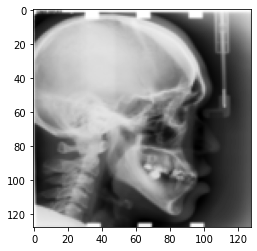

In [8]:
plt.imshow(X_train[0], cmap='gray')

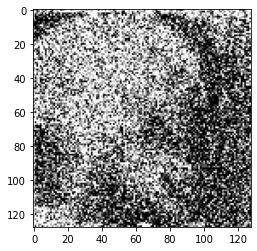

In [9]:
plt.imshow(X_train_noisy[0], cmap='gray')

## CREATE AUTO-ENCODER ARCHITECTURE

In [10]:
lam = tf.keras.regularizers.l1(l=0)
input_img = tf.keras.layers.Input(shape=(d, d, 1))
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=lam)(input_img)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)
# x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)
# x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)

# x = tf.keras.layers.Conv2DTranspose(8, kernel_size=3, activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)
# x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=lam)(x)
x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=lam)(x)
x = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=lam)(x)
# x = tf.keras.layers.Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=lam)(x)
decoder_output = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=lam)(x)
autoencoder = tf.keras.Model(input_img, decoder_output)

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      4624  

In [12]:
autoencoder.compile(optimizer='adam', loss='mse')

## TRAIN THE MODEL

In [13]:
history = autoencoder.fit(X_train_noisy, X_train, epochs=150, batch_size=64, validation_split=0.2)

Epoch 1/150
20/20 [==============================] - 16s 308ms/step - loss: 0.0886 - val_loss: 0.0879
Epoch 2/150
20/20 [==============================] - 5s 266ms/step - loss: 0.0862 - val_loss: 0.0845
Epoch 3/150
20/20 [==============================] - 5s 252ms/step - loss: 0.0769 - val_loss: 0.0345
Epoch 4/150
20/20 [==============================] - 5s 251ms/step - loss: 0.0266 - val_loss: 0.0183
Epoch 5/150
20/20 [==============================] - 5s 256ms/step - loss: 0.0169 - val_loss: 0.0141
Epoch 6/150
20/20 [==============================] - 5s 266ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 7/150
20/20 [==============================] - 5s 269ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 8/150
20/20 [==============================] - 5s 257ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 9/150
20/20 [==============================] - 5s 253ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 10/150
20/20 [==============================] - 5s 253ms/step - loss: 0.0104 - val_l

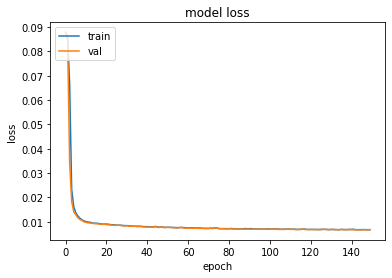

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
tf.keras.models.save_model(autoencoder, 'Model/model_noise-0.5.h5')

In [16]:
autoencoder = tf.keras.models.load_model('Model/model_noise-0.5.h5')

## TEST THE MODEL

In [17]:
X_test_decoded = autoencoder(X_test_noisy)

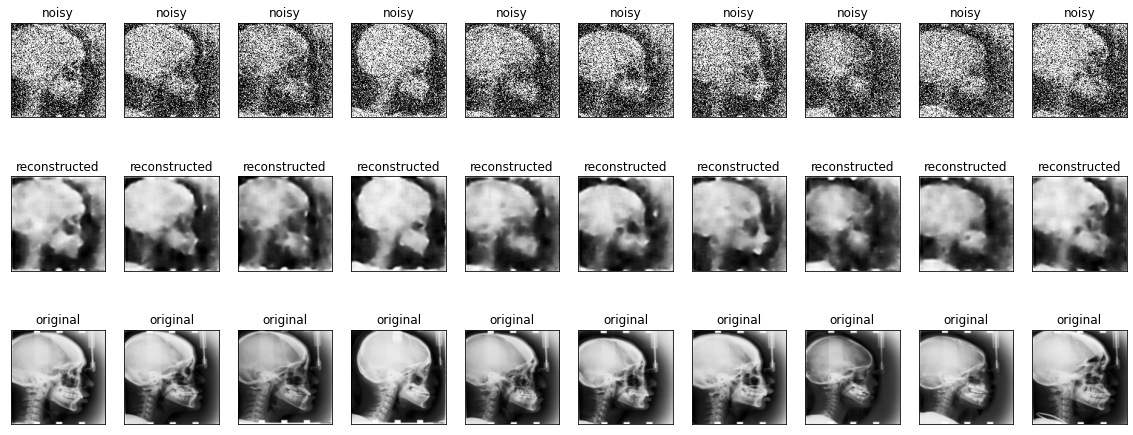

In [18]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ii = np.random.randint(0, 80);
    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("noisy")
    plt.imshow(tf.squeeze(X_test_noisy[ii]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(X_test_decoded[ii]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display original
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[ii]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)


plt.show()

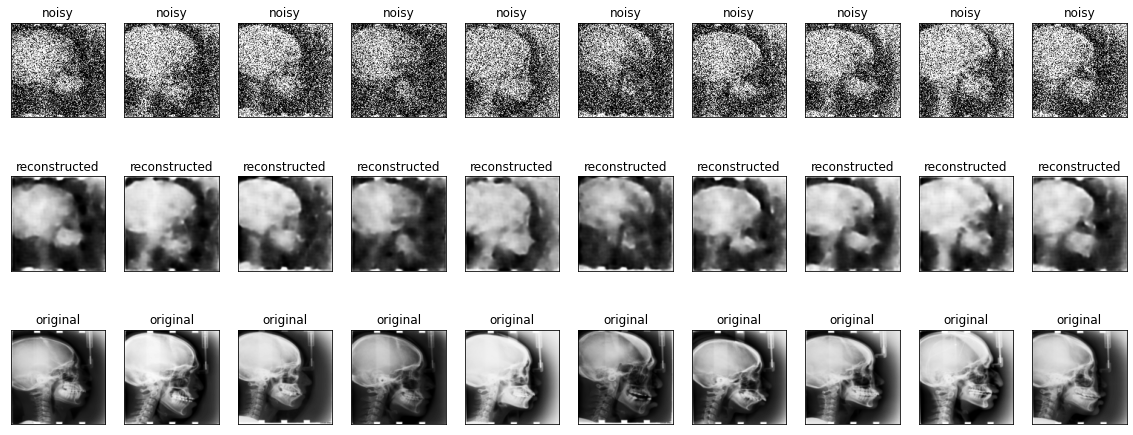

In [19]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ii = np.random.randint(0, 80);
    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("noisy")
    plt.imshow(tf.squeeze(X_test_noisy[ii]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(X_test_decoded[ii]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display original
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[ii]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)


plt.show()

## PERFORM MEDIAN FILTERING

In [20]:
X_test_median = np.zeros_like(X_test_noisy)
for i in range(X_test.shape[0]):
    X_test_median[i] = median_filter(np.array(X_test_noisy[i]), size=3)

In [21]:
X_test_median.shape

(80, 128, 128, 1)

## COMPARE PERFOMANCES

In [22]:
ssim_avg_noisy = []
ssim_avg_median = []
ssim_avg_reconstructed = []
for i in range(X_test.shape[0]):
    ssim_avg_noisy.append(structural_similarity(np.array(X_test[i]), np.array(X_test_noisy[i]), data_range=1, multichannel=True))
    ssim_avg_reconstructed.append(structural_similarity(np.array(X_test[i]), np.array(X_test_decoded[i]), data_range=1, multichannel=True))
    ssim_avg_median.append(structural_similarity(np.array(X_test[i]), np.array(X_test_median[i]), data_range=1, multichannel=True))
print("Structural similarity between Original and Noisy Image - " + str(np.mean(ssim_avg_noisy)))
print("Sructural similiarity between Original and Reconstructed Image - " + str(np.mean(ssim_avg_reconstructed)))
print("Sructural similiarity between Original and Median-filtered Image - " + str(np.mean(ssim_avg_median)))

Structural similarity between Original and Noisy Image - 0.07879963236821037
Sructural similiarity between Original and Reconstructed Image - 0.6625391674743311
Sructural similiarity between Original and Median-filtered Image - 0.21464225668241
